In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def extract_sections_from_excel(section_names: List[str], df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Extracts specific sections from a DataFrame based on section names.

    Args:
        section_names: A list of section names to extract from the DataFrame.
        df: The DataFrame containing the data to extract sections from.

    Returns:
        A dictionary where keys are section names and values are DataFrames
        containing the data for each section.

    Notes:
        - The function assumes that the section names are present in the first column of the DataFrame.
        - If a section name is not found, a warning is printed, and the section is skipped.
        - The extracted sections are sorted based on their order of appearance in the DataFrame.
    """
    # Remove rows where the first column is empty or contains only whitespace
    df = df[df.iloc[:, 0].str.strip().astype(bool)]

    # Remove empty rows and columns
    df = df.dropna(how='all', axis=0)  # Drop rows where all elements are NaN
    df = df.dropna(how='all', axis=1)  # Drop columns where all elements are NaN

    # Find the starting index of each section by matching the first column
    section_starts: Dict[str, int] = {}
    for name in section_names:
        matching_rows = df[df.iloc[:, 0].str.strip() == name]  # Match section names in the first column
        if not matching_rows.empty:
            section_starts[name] = matching_rows.index[0]  # Store the starting index of the section
        else:
            print(f"Warning: Section '{name}' not found in the DataFrame.")  # Warn if a section is missing

    # Sort the sections by their starting indices
    sorted_sections: List[tuple[str, int]] = sorted(section_starts.items(), key=lambda x: x[1])

    # Build a dictionary to store each section as a separate DataFrame
    sections: Dict[str, pd.DataFrame] = {}
    for i, (name, start_idx) in enumerate(sorted_sections):
        # Determine the end index of the current section
        end_idx: int = sorted_sections[i + 1][1] if i + 1 < len(sorted_sections) else len(df)
        
        # Extract the section data
        section_df: pd.DataFrame = df.iloc[start_idx + 1:end_idx].copy()
        
        # Ensure all sections use the same column names as the main DataFrame
        section_df.columns = df.columns
        
        # Store the section DataFrame in the dictionary
        sections[name] = section_df

        # Apply formatting to all sections
    for section_name, section_df in sections.items():
        # Transpose the data for better readability
        formatted_section = section_df.iloc[:, 1:].T  # Exclude the first column (assumed to be labels)
        formatted_section.columns = section_df['Characteristic by Month'].values  # Set new column names
        
        # Convert all data to numeric, coercing errors to NaN
        formatted_section = formatted_section.apply(pd.to_numeric, errors='coerce')
        
        # Set the index to datetime for time-series analysis
        formatted_section.index = pd.to_datetime(formatted_section.index)
        formatted_section.index.name = 'Month'  # Name the index as 'Month'
        
        # Update the section with the formatted DataFrame
        sections[section_name] = formatted_section

    return sections

# Data extraction and analysis

This notebook is created specifically for data analysis and extracting the relevant statistics for `Project 2.2: Hospital Simulation`.

This is a discrete event simulation of an hospital emergency department. Relevant data extracted for this project is:

- **Patient arrival:** defines how many patient arrive every day.
- **Patient diagnosis:** gives the patient a diagnosis such that it can be classified within a triage system.
- **Treatment times:** per diagnosis give a specific treatment times. 

## Patient arrival function

To extract this data we use the following resources.

In [3]:
# Load the first Excel file and parse the relevant sheet
file_path = 'HCUP_SummaryTrendTables_T1.xlsx'
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Oregon')  # Replace 'Oregon' with the actual sheet name if different

# Set the column names to reflect the Excel file's structure
df.columns = df.iloc[4]  # Promote the 5th row as column headers
df = df[4:].reset_index(drop=True)  # Remove the header row from the data


section_names_T1 = [
    "Inpatient Stays",
    "Occupancy",
    "Intensive Care Use",
    "Intensive Care Beds",
    "Mechanical Ventilator Use",
    "Number of Mechanical Ventilators (outside of the operating rooms)",
    "Emergency Department (ED) Visits",
    "ED Volume" ,
    "ED Admission Rate"
]

sections_T1 = extract_sections_from_excel(section_names_T1, df)

# Print the names of the extracted sections
print("Sections extracted:", list(sections_T1.keys()))

Sections extracted: ['Inpatient Stays', 'Occupancy', 'Intensive Care Use', 'Intensive Care Beds', 'Mechanical Ventilator Use', 'Number of Mechanical Ventilators (outside of the operating rooms)', 'Emergency Department (ED) Visits', 'ED Volume', 'ED Admission Rate']


We exclude the data from January 2020 up to April 2023. Reason being the Covid-19 pandemic which lasted between the months according to the WHO.   
Sources: [start](https://www.who.int/news/item/29-06-2020-covidtimeline) – [end](https://www.reuters.com/business/healthcare-pharmaceuticals/covid-is-no-longer-global-health-emergency-who-2023-05-05/)

In [4]:
ed_visits = sections_T1['ED Volume'][['Average daily volume for all ED visits', 'Minimum daily volume for all ED visits', 'Maximum daily volume for all ED visits']]
# Exclude COVID-19 years (2020 and later)
pre_covid = ed_visits.loc[ed_visits.index < '2020-01-01']

# Calculate monthly averages for each calendar month (pre-COVID)
monthly_avg = pre_covid.groupby(pre_covid.index.month)['Average daily volume for all ED visits'].mean()
months = np.arange(1, 13)  # 1 to 12

### Seasonal trends: 

ED volumes show moderate seasonal variation. The winter months the numbers of visits tends to be higher (+- 2%), while spring/summer months have a slightly lower volume compared to the yearly average. We can account for this using a seasonal factor. To reflect this seasonality in our data, we apply a seasonal factor to the baseline arrival rate. The factor is calculated by evaluating a sinusoidal that is fitted to historic data. These findings are also confirmed by other studies in hospitals worldwide (Gabbay, 2022).

The fitted seasonal function is:

$$
f(m) = A \cdot \sin\left(\frac{2\pi (m-1)}{12} + \phi\right) + B
$$

where:
-  $m$  is the month number (1 = January, ..., 12 = December)
-  $A = 87.81$  (amplitude, seasonal variation)
-  $\phi = 0.13$  (phase shift, in radians)
-  $B = 4237.56$  (baseline average daily arrivals)

These parameter values are estimated from the pre-COVID data using nonlinear curve fitting.

fitted curve parameters: A = 87.808431; phi = 0.132320; B = 4237.560076


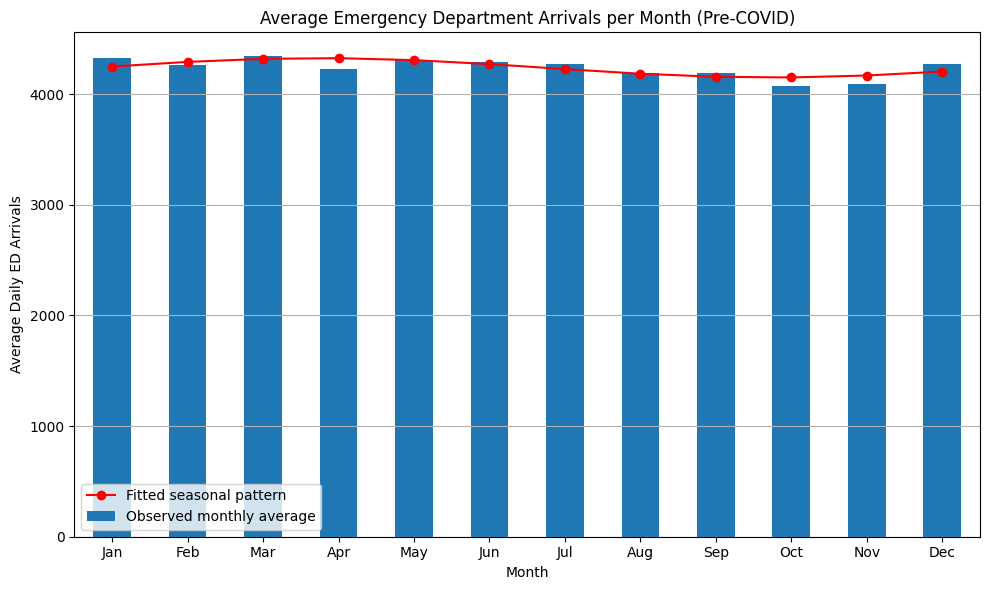

In [5]:
# fitting sinusoidal function to the seasonal trend
def seasonal_func(t, A, phi, B):
    # t: month number (1-12)
    return A * np.sin(2 * np.pi * (t-1) / 12 + phi) + B

# Fit the function to your monthly averages
params, _ = curve_fit(seasonal_func, months, monthly_avg.values)
A, phi, B = params
print(f"fitted curve parameters: {A = :0.6f}; {phi = :0.6f}; {B = :0.6f}")

# Plot the seasonal trend and the fitted function
ax = monthly_avg.plot(kind='bar', figsize=(10, 6), label='Observed monthly average')
ax.plot(np.arange(12), seasonal_func(months, *params), color='red', marker='o', linestyle='-', label='Fitted seasonal pattern')


plt.xlabel('Month')
plt.ylabel('Average Daily ED Arrivals')
plt.title('Average Emergency Department Arrivals per Month (Pre-COVID)')
plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


**Figure:** Average daily Emergency Department (ED) arrivals per month in Oregon (pre-COVID, 2017–2019). The blue bars show the observed monthly averages, while the red line represents a fitted seasonal sinusoidal function.

This plot illustrates the moderate seasonal variation in ED arrivals, with higher volumes in winter and lower in summer. The fitted curve quantifies this seasonality, with an amplitude of approximately 88 patients, a baseline of 4238, and a small phase shift. These parameters are used to model monthly arrival rates in the hospital simulation.

**references:**
- Gabbay, Uri MD, MPHa,b,*; Drescher, Michael J MDa,c. Daily output measures of Emergency Department in association with seasonality and day of the week: A retrospective cohort observational study. Medicine 101(36):p e30555, September 09, 2022. | DOI: 10.1097/MD.0000000000030555 

### Day-of-the-week trends:


ED arrivals vary by day if the week. In general, monday is the busiest, as many people [defer care over the weekend](https://www.immediatecarewestmont.com/what-is-the-busiest-day-at-the-er/#:~:text=So%2C%20does%20the%20ER%20have,week%3F%20Let%E2%80%99s%20break%20it%20down). Volumes then lower midweek and are lowest on weekends (especially Sunday). We can incorporate this using a weekday factor that scales the arrivals according to the weekday.

**TO DO:** find exact number to base the factors on.

- https://www.researchgate.net/publication/350073202_Forecasting_emergency_department_admissions (week, day)
- https://pubmed.ncbi.nlm.nih.gov/37868675/#:~:text=then%20calculated%20separately%20for%20each,management%2C%20and%20reducing%20healthcare%20costs (week)
- https://pubmed.ncbi.nlm.nih.gov/37868675/#:~:text=then%20calculated%20separately%20for%20each,management%2C%20and%20reducing%20healthcare%20costs (week) 
- https://www.cdc.gov/nchs/data/nhamcs/web_tables/2019-nhamcs-ed-web-tables-508.pdf#:~:text=Patient%20arrived%20in%20emergency%20department,for%20Health%20Statistics%20standards%20of (other)

### Hour-of-the-day trends:

Within each day arrivals follow a diurnal (daily) cycle. we can account for this using a hourly factor.

**TO DO:**  find exact sources to base the factors on.

- https://www.acepnow.com/article/when-do-patients-arrive-in-the-emergency-department/#:~:text=Most%20emergency%20departments%20have%20a,number%20increases%20to%2062%20percent (day)
- https://www.researchgate.net/publication/350073202_Forecasting_emergency_department_admissions (week, day)
- https://www.cdc.gov/nchs/data/nhamcs/web_tables/2019-nhamcs-ed-web-tables-508.pdf#:~:text=Patient%20arrived%20in%20emergency%20department,for%20Health%20Statistics%20standards%20of (other)

### Final arrival rate:

Using these factors, the arrival rate λ for a given hour h on date d can be estimated as: 

$$
    \lambda(m,d,h) =  f(m) \times F_\text{weekday}(d) \times F_\text{hour}(h)
$$
- $f(m)$ is the fitted function described in section Seasonal trends. This gives us the daily average per month accounted for seasonal fluctuations.
- $F_\text{i}$ are multipliers for season, weekday, and hour.

For simulation: treat arrivals as a Poisson process with mean $\lambda(m,d,h)$ for each hour. Then sample the number of arrivals in that hour from Poisson($\lambda$).

## Generating patient diagnosis distributions

When simulating patient arrivals, assign each patient a diagnosis in proportion to real-world frequencies. We use the HCUP data (pre-covid) to derive these distributions.

In [6]:
file_path = 'HCUP_SummaryTrendTables_T16a.xlsx'
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Oregon')
df.columns = df.iloc[5]
df = df[5:].reset_index(drop=True)

section_names_T16a = [
    "Number of ED  Visits for the Month",
    "Number of ED Treat-and-Release Visits by Priority Condition",
    "Number of ED Treat-and-Release Visits by Age in Years at Admission",
    "Number of ED Treat-and-Release Visits by Sex",
    "Number of ED Treat-and-Release Visits by Patient Race and Ethnicity",
    "Number of ED Treat-and-Release Visits by Urban-Rural Location of Patient's Residence",
    "Number of ED Treat-and-Release Visits by Community Income",
    "Number of ED Treat-and-Release Visits by Expected Primary Payer",
    "Number of ED Treat-and-Release Visits by Urban-Rural Location of the Hospital",
    "Number of ED Treat-and-Release Visits for Top Conditions Defined by First-Listed Diagnosis",
    "Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis"
]

sections_T16a = extract_sections_from_excel(section_names_T16a, df)

print("Sections extracted:", list(sections_T16a.keys()))

ed_diagnosis = sections_T16a['Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis']

# # Exclude COVID-19 years (2020 and later)
pre_covid_diagnosis = ed_diagnosis.loc[ed_diagnosis.index < '2020-01-01']

pre_covid_diagnosis.head()

Sections extracted: ['Number of ED  Visits for the Month', 'Number of ED Treat-and-Release Visits by Priority Condition', 'Number of ED Treat-and-Release Visits by Age in Years at Admission', 'Number of ED Treat-and-Release Visits by Sex', 'Number of ED Treat-and-Release Visits by Patient Race and Ethnicity', "Number of ED Treat-and-Release Visits by Urban-Rural Location of Patient's Residence", 'Number of ED Treat-and-Release Visits by Community Income', 'Number of ED Treat-and-Release Visits by Expected Primary Payer', 'Number of ED Treat-and-Release Visits by Urban-Rural Location of the Hospital', 'Number of ED Treat-and-Release Visits for Top Conditions Defined by First-Listed Diagnosis', 'Number of ED Treat-and-Release Visits for Symptoms Defined by Any-Listed Diagnosis']


,SYM001 Syncope,SYM002 Fever,SYM003 Shock,SYM004 Nausea and vomiting,SYM005 Dysphagia,SYM006 Abdominal pain and other digestive/abdomen signs and symptoms,SYM007 Malaise and fatigue,SYM008 Symptoms of mental and substance use conditions,SYM009 Abnormal findings related to substance use,SYM010 Nervous system signs and symptoms,SYM011 Genitourinary signs and symptoms,SYM012 Circulatory signs and symptoms,SYM013 Respiratory signs and symptoms,SYM014 Skin/Subcutaneous signs and symptoms,SYM015 General sensation/perception signs and symptoms,SYM016 Other general signs and symptoms,SYM017 Abnormal findings without diagnosis
Month,,,,,,,,,,,,,,,,,
2017-01-01,1925.0,2451.0,39.0,7751.0,219.0,11373.0,2405.0,546.0,NaN,5753.0,1457.0,3271.0,8124.0,2147.0,2487.0,2479.0,3189.0
2017-02-01,1897.0,2074.0,39.0,7426.0,205.0,11089.0,2074.0,575.0,NaN,5144.0,1359.0,3187.0,6999.0,2044.0,2443.0,2210.0,3046.0
2017-03-01,2038.0,2150.0,31.0,8496.0,293.0,12658.0,2387.0,594.0,NaN,5753.0,1515.0,3576.0,7190.0,2371.0,2641.0,2634.0,3425.0
2017-04-01,1960.0,1990.0,23.0,8129.0,268.0,12162.0,2332.0,604.0,NaN,5614.0,1445.0,3425.0,6549.0,2278.0,2585.0,2563.0,3147.0
2017-05-01,2183.0,2288.0,32.0,8377.0,275.0,12249.0,2596.0,632.0,NaN,5889.0,1558.0,3688.0,6592.0,2572.0,2816.0,2759.0,3263.0


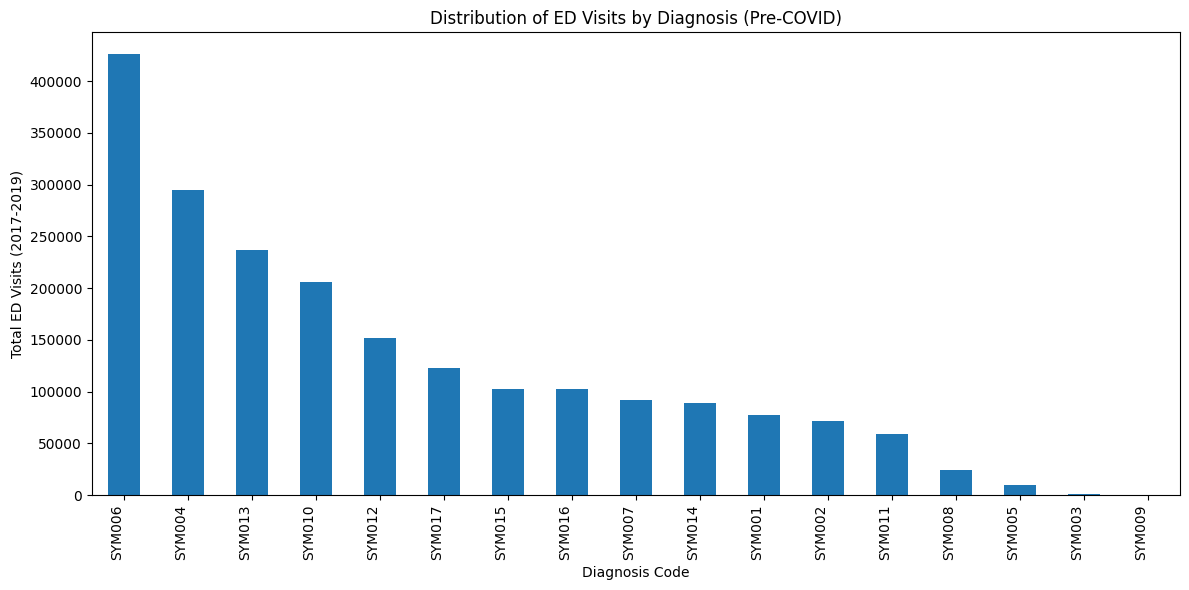

In [7]:


# Calculate total ED visits for each diagnosis code (sum over all months, pre-COVID)
diagnosis_totals = pre_covid_diagnosis.sum(axis=0)

# Transform the labels to only include the SYM code
diagnosis_totals.index = diagnosis_totals.index.str.extract(r'(SYM\d+)', expand=False)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
diagnosis_totals.sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Total ED Visits (2017-2019)')
plt.xlabel('Diagnosis Code')
plt.title('Distribution of ED Visits by Diagnosis (Pre-COVID)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

- **SYM001** Syncope  
- **SYM002** Fever  
- **SYM003** Shock  
- **SYM004** Nausea and vomiting  
- **SYM005** Dysphagia  
- **SYM006** Abdominal pain and other digestive/abdomen signs and symptoms  
- **SYM007** Malaise and fatigue  
- **SYM008** Symptoms of mental and substance use conditions  
- **SYM009** Abnormal findings related to substance use  
- **SYM010** Nervous system signs and symptoms  
- **SYM011** Genitourinary signs and symptoms  
- **SYM012** Circulatory signs and symptoms  
- **SYM013** Respiratory signs and symptoms  
- **SYM014** Skin/Subcutaneous signs and symptoms  
- **SYM015** General sensation/perception signs and symptoms  
- **SYM016** Other general signs and symptoms  
- **SYM017** Abnormal findings without diagnosis

In [8]:
# Create a discrete probability distribution for diagnosis codes based on pre-COVID totals
diagnosis_codes = diagnosis_totals.index.values
diagnosis_probs = diagnosis_totals.values / diagnosis_totals.values.sum()

def sample_diagnosis(n=1):
    """
    Sample diagnosis codes according to their observed frequencies.
    Args:
        n: Number of samples to draw.
    Returns:
        Array of sampled diagnosis codes.
    """
    return np.random.choice(diagnosis_codes, size=n, p=diagnosis_probs)

print(f"{diagnosis_codes = }\n[{diagnosis_probs = }]")

# Example: sample 5 diagnoses
sampled = sample_diagnosis(5)
print("Sampled diagnoses:", sampled)

diagnosis_codes = array(['SYM001', 'SYM002', 'SYM003', 'SYM004', 'SYM005', 'SYM006',
       'SYM007', 'SYM008', 'SYM009', 'SYM010', 'SYM011', 'SYM012',
       'SYM013', 'SYM014', 'SYM015', 'SYM016', 'SYM017'], dtype=object)
[diagnosis_probs = array([3.72908417e-02, 3.45021445e-02, 6.44438692e-04, 1.42655116e-01,
       4.82845207e-03, 2.06028792e-01, 4.42272662e-02, 1.19613046e-02,
       6.28956682e-06, 9.97375315e-02, 2.83615920e-02, 7.33431225e-02,
       1.14778789e-01, 4.28604950e-02, 4.97795023e-02, 4.95869448e-02,
       5.94073777e-02])]
Sampled diagnoses: ['SYM017' 'SYM006' 'SYM006' 'SYM004' 'SYM013']
